# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.image import imread
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

D0716 19:45:18.131688399      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0716 19:45:18.131713735      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0716 19:45:18.131717024      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0716 19:45:18.131719832      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0716 19:45:18.131722360      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0716 19:45:18.131724910      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0716 19:45:18.131728494      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0716 19:45:18.

In [2]:
root_dir = '/kaggle/input/polish-traffic-signs-dataset/'

train_dir = 'train'
val_dir = 'test'

IMG_HEIGHT = 32
IMG_WIDTH = 32

<div class="alert alert-block alert-info" style="color: #000000;">
    
Because images are grouped into catalogs and every catalog is named as the class it contains, we can use Tensorflow's ImageDataGenerator. It's method `flow_from_directory` recognizes classes of data from the path of the files.

</div>



In [3]:
# first, instantiate ImageDataGenerator for training and validation data
# we will rescale the data so the target values are between 0 and 1

train_image_generator = ImageDataGenerator(rescale=1./255)
val_image_generator = ImageDataGenerator(rescale=1./255)

<div class="alert alert-block alert-info" style="color: #000000;">

Define train set and validation set using `flow_from_directory`.

</div>

In [4]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=100,
                                                          directory=root_dir + train_dir,
                                                          class_mode='sparse',
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 16746 images belonging to 92 classes.


In [5]:
# define validation set
val_data_gen = val_image_generator.flow_from_directory(batch_size=100,
                                                       directory=root_dir + val_dir,
                                                       class_mode='sparse',
                                                       shuffle=False,
                                                       target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 4298 images belonging to 92 classes.


<div class="alert alert-block alert-info" style="color: #000000;">

I use sparse class mode because it will prepare the labels for `sparse_categorical_crossentropy` loss. We use it when classes are mutually exclusive, and here, we have such case. 

</div>

# Images Visualisation

In [6]:
CLASSES = train_data_gen.num_classes
CLASSES

92

<div class="alert alert-block alert-info" style="color: #000000;">
We have 92 classes of polish traffic signs.

Here is a list of their names and titles:
</div>

In [7]:
class_names = {
            'A-1': 'Niebezpieczny zakręt w prawo',
            'A-11': 'Nierówna droga',
            'A-11a': 'Próg zwalniający',
            'A-12a': 'Zwężenie jezdni - dwustronne',
            'A-14': 'Roboty drogowe',
            'A-15': 'Śliska jezdnia',
            'A-16': 'Przejście dla pieszych',
            'A-17': 'Dzieci',
            'A-18b': 'Zwierzęta dzikie',
            'A-2': 'Niebezpieczny zakręt w lewo',
            'A-20': 'Odcinek jezdni o ruchu dwukierunkowym',
            'A-21': 'Tramwaj',
            'A-24': 'Rowerzyści',
            'A-29': 'Sygnały świetlne',
            'A-3': 'Niebezpieczne zakręty, pierwszy w prawo',
            'A-30': 'Inne niebezpieczeństwo',
            'A-32': 'Oszronienie jezdni',
            'A-4': 'Niebezpieczne zakręty, pierwszy w lewo',
            'A-6a': 'Skrzyżowanie z drogą podporządkowaną występującą po obu stronach',
            'A-6b': 'Skrzyżowanie z drogą podporządkowaną występującą po prawej stronie',
            'A-6c': 'Skrzyżowanie z drogą podporządkowaną występującą po lewej stronie',
            'A-6d': 'Wlot drogi jednokierunkowej z prawej strony',
            'A-6e': 'Wlot drogi jednokierunkowej z lewej strony',
            'A-7': 'Ustąp pierwszeństwa',
            'A-8': 'Skrzyżowanie o ruchu okrężnym',
            'B-1': 'Zakaz ruchu w obu kierunkach',
            'B-18': 'Zakaz wjazdu pojazdów o rzeczywistej masie całkowitej ponad ... t.',
            'B-2': 'Zakaz wjazdu',
            'B-20': 'STOP',
            'B-21': 'Zakaz skręcania w lewo',
            'B-22': 'Zakaz skręcania w prawo',
            'B-25': 'Zakaz wyprzedzania',
            'B-26': 'Zakaz wyprzedzania przez samochody ciężarowe',
            'B-27': 'Koniec zakazu wyprzedzania',
            'B-33': 'Ograniczenie prędkości',
            'B-34': 'Koniec ograniczenia prędkości',
            'B-36': 'Zakaz zatrzymywania się',
            'B-41': 'Zakaz ruchu pieszych',
            'B-42': 'Koniec zakazów',
            'B-43': 'Strefa ograniczonej prędkości',
            'B-44': 'Koniec strefy ograniczonej prędkości',
            'B-5': 'Zakaz wjazdu samochodów ciężarowych',
            'B-6-B-8-B-9': 'Zakaz wjazdu pojazdów innych niż samochodowe',
            'B-8': 'Zakaz wjazdu pojazdów zaprzęgowych',
            'B-9': 'Zakaz wjazdu rowerów',
            'C-10': 'Nakaz jazdy z lewej strony znaku',
            'C-12': 'Ruch okrężny',
            'C-13': 'Droga dla rowerów',
            'C-13-C-16': 'Droga dla pieszych i rowerzystów',
            'C-13a': 'Koniec drogi dla rowerów',
            'C-13a-C-16a': 'Koniec drogi dla pieszych i rowerzystów',
            'C-16': 'Droga dla pieszych',
            'C-2': 'Nakaz jazdy w prawo za znakiem',
            'C-4': 'Nakaz jazdy w lewo za znakiem',
            'C-5': 'Nakaz jazdy prosto',
            'C-6': 'Nakaz jazdy prosto lub w prawo',
            'C-7': 'Nakaz jazdy prosto lub w lewo',
            'C-9': 'Nakaz jazdy z prawej strony znaku',
            'D-1': 'Droga z pierwszeństwem',
            'D-14': 'Koniec pasa ruchu',
            'D-15': 'Przystanek autobusowy',
            'D-18': 'Parking',
            'D-18b': 'Parking zadaszony',
            'D-2': 'Koniec drogi z pierwszeństwem',
            'D-21': 'Szpital',
            'D-23': 'Stacja paliwowa',
            'D-23a': 'Stacja paliwowa tylko z gazem do napędu pojazdów',
            'D-24': 'Telefon',
            'D-26': 'Stacja obsługi technicznej',
            'D-26b': 'Myjnia',
            'D-26c': 'Toaleta publiczna',
            'D-27': 'Bufet lub kawiarnia',
            'D-28': 'Restauracja',
            'D-29': 'Hotel (motel)',
            'D-3': 'Droga jednokierunkowa',
            'D-40': 'Strefa zamieszkania',
            'D-41': 'Koniec strefy zamieszkania',
            'D-42': 'Obszar zabudowany',
            'D-43': 'Koniec obszaru zabudowanego',
            'D-4a': 'Droga bez przejazdu',
            'D-4b': 'Wjazd na drogę bez przejazdu',
            'D-51': 'Automatyczna kontrola prędkości',
            'D-52': 'Strefa ruchu',
            'D-53': 'Koniec strefy ruchu',
            'D-6': 'Przejście dla pieszych',
            'D-6b': 'Przejście dla pieszych i przejazd dla rowerzystów',
            'D-7': 'Droga ekspresowa',
            'D-8': 'Koniec drogi ekspresowej',
            'D-9': 'Autostrada',
            'D-tablica': 'Zbiorcza tablica informacyjna',
            'G-1a': 'Słupek wskaźnikowy z trzema kreskami umieszczany po prawej stronie jezdni',
            'G-3': 'Krzyż św. Andrzeja przed przejazdem kolejowym jednotorowym'
        }

class_names

{'A-1': 'Niebezpieczny zakręt w prawo',
 'A-11': 'Nierówna droga',
 'A-11a': 'Próg zwalniający',
 'A-12a': 'Zwężenie jezdni - dwustronne',
 'A-14': 'Roboty drogowe',
 'A-15': 'Śliska jezdnia',
 'A-16': 'Przejście dla pieszych',
 'A-17': 'Dzieci',
 'A-18b': 'Zwierzęta dzikie',
 'A-2': 'Niebezpieczny zakręt w lewo',
 'A-20': 'Odcinek jezdni o ruchu dwukierunkowym',
 'A-21': 'Tramwaj',
 'A-24': 'Rowerzyści',
 'A-29': 'Sygnały świetlne',
 'A-3': 'Niebezpieczne zakręty, pierwszy w prawo',
 'A-30': 'Inne niebezpieczeństwo',
 'A-32': 'Oszronienie jezdni',
 'A-4': 'Niebezpieczne zakręty, pierwszy w lewo',
 'A-6a': 'Skrzyżowanie z drogą podporządkowaną występującą po obu stronach',
 'A-6b': 'Skrzyżowanie z drogą podporządkowaną występującą po prawej stronie',
 'A-6c': 'Skrzyżowanie z drogą podporządkowaną występującą po lewej stronie',
 'A-6d': 'Wlot drogi jednokierunkowej z prawej strony',
 'A-6e': 'Wlot drogi jednokierunkowej z lewej strony',
 'A-7': 'Ustąp pierwszeństwa',
 'A-8': 'Skrzyżowan

<div class="alert alert-block alert-info" style="color: #000000;">

Let's look at some random images.    
</div>

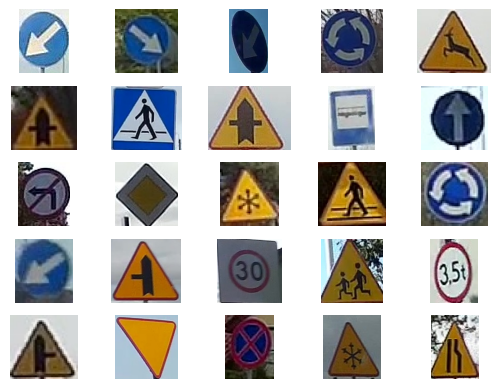

In [8]:
fig, axs = plt.subplots(nrows=5, ncols=5)

for i in range(5):
    for j in range(5):
        sample = random.choice(train_data_gen.filenames)
        image = load_img(root_dir + train_dir + '/' + sample)
        axs[j][i].imshow(image)
        axs[j][i].axis('off')
        

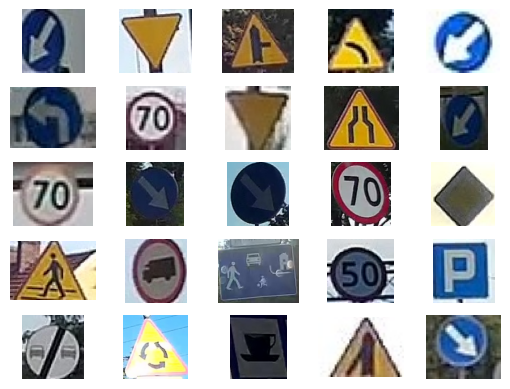

In [9]:
fig, axs = plt.subplots(nrows=5, ncols=5)

for i in range(5):
    for j in range(5):
        sample = random.choice(val_data_gen.filenames)
        image = load_img(root_dir + val_dir + '/' + sample)
        axs[j][i].imshow(image)
        axs[j][i].axis('off')       

# Basic model

<div class="alert alert-block alert-info" style="color: #000000;">

Convolutonal Neural Networks have become the "go to" model for image classification. They are able to extract important and distinctive features of images for each class.

They are comprised of 3 types of layers: convolutional layers, pool layers and fully connected layers.

For the first model I will use a simple network based on LeNet-5 architecture (more info <a href="https://www.kaggle.com/code/blurredmachine/lenet-architecture-a-complete-guide">here</a>).

</div>

In [10]:
basic = Sequential([
    Conv2D(30, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(15, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(CLASSES, activation='softmax')
])
basic.compile(Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
history_1 = basic.fit(train_data_gen, 
                      steps_per_epoch = int(np.ceil(train_data_gen.samples / 100)),
                      epochs=10,
                      validation_data=val_data_gen,
                      validation_steps = int(np.ceil(val_data_gen.samples / 100)),
                      verbose=0)

In [12]:
# define a function for plotting accuracy and loss
# and to view the values in numeric amounts

def acc_loss_eval(history, model):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(history.epoch))
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()
    
    model.evaluate(val_data_gen)

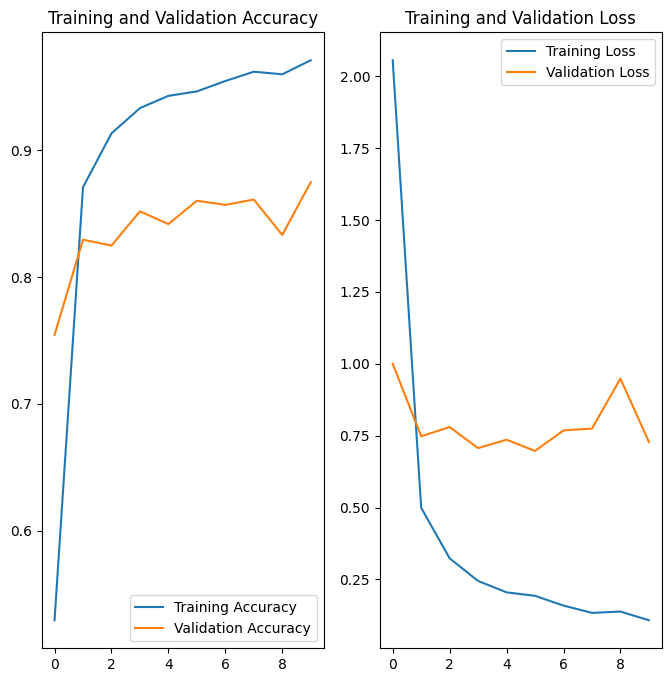

43/43 [==============================] - 4s 94ms/step - loss: 0.7283 - accuracy: 0.8748


In [13]:
acc_loss_eval(history_1, basic)

<div class="alert alert-block alert-info" style="color: #000000;">
The most basic convolutional neural network gives us accuracy over 80%. That's not bad but we can increase this value.

What is more, the validation accuracy is much lower than training accuracy, which means the model is overfitting on the training data. This is important to address in next training runs.
</div>

# Fine-tuning Model

<div class="alert alert-block alert-info" style="color: #000000;">
To increase the accuracy, we can increase the number of filters in Convolutional layer - this will help extract more features.
</div>

In [14]:
more_filters = Sequential([
    Conv2D(60, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),  # increasing filters from 30 to 60
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(30, (3, 3), activation='relu'),  # and here from 15 to 30
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(CLASSES, activation='softmax')
])

more_filters.compile(Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_2 = more_filters.fit(train_data_gen, 
                      steps_per_epoch = int(np.ceil(train_data_gen.samples / 100)),
                      epochs=10,
                      validation_data=val_data_gen,
                      validation_steps = int(np.ceil(val_data_gen.samples / 100)),
                      verbose=0)

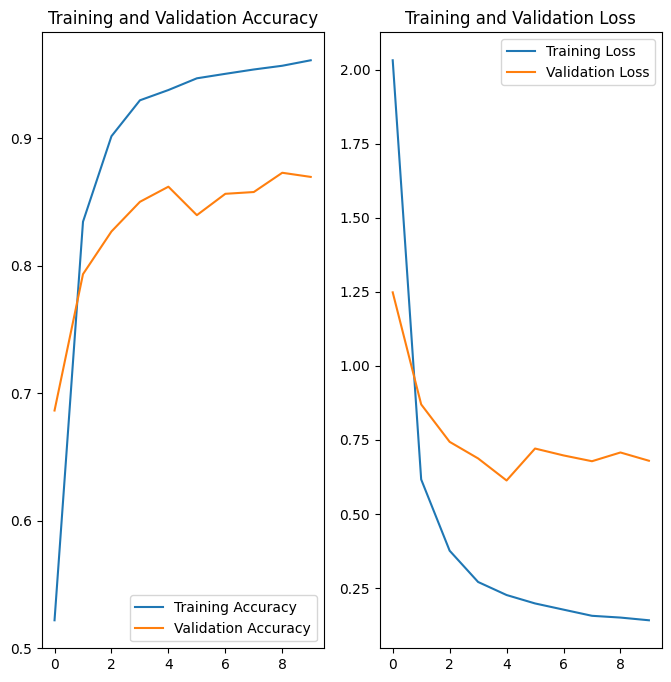

43/43 [==============================] - 4s 95ms/step - loss: 0.6798 - accuracy: 0.8697


In [15]:
acc_loss_eval(history_2, more_filters)

<div class="alert alert-block alert-info" style="color: #000000;">
Another way to increase accuracy is to simply add more convolution layers. This will help extract features more effectively.
</div>

In [16]:
more_layers = Sequential([
    Conv2D(60, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'), 
    Conv2D(60, (5, 5), activation='relu'),  # extra conv layer
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(30, (3, 3), activation='relu'),
    Conv2D(30, (3, 3), activation='relu'),  # extra conv layer
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(500, activation='relu'),
    Dense(CLASSES, activation='softmax')
])

more_layers.compile(Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_3 = more_layers.fit(train_data_gen, 
                      steps_per_epoch = int(np.ceil(train_data_gen.samples / 100)),
                      epochs=10,
                      validation_data=val_data_gen,
                      validation_steps = int(np.ceil(val_data_gen.samples / 100)),
                      verbose=0)

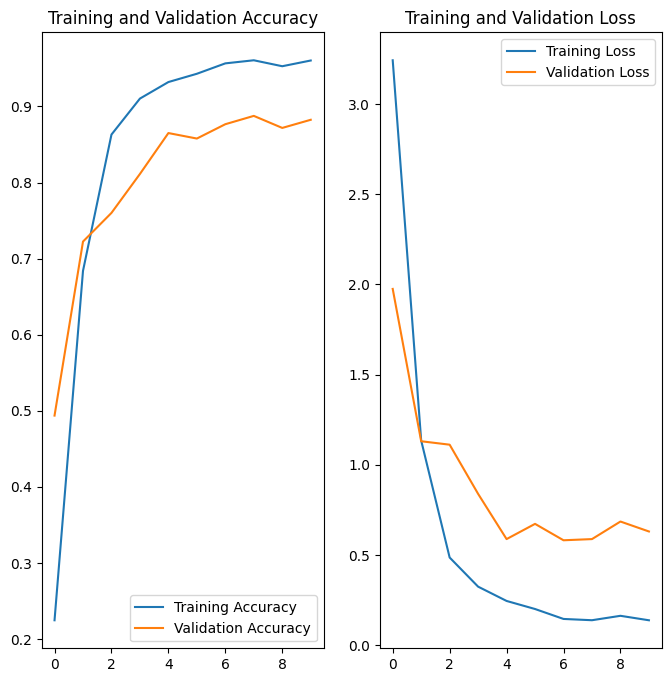

43/43 [==============================] - 5s 113ms/step - loss: 0.6310 - accuracy: 0.8825


In [17]:
acc_loss_eval(history_3, more_layers)

<div class="alert alert-block alert-info" style="color: #000000;">
We can also experiment with Adam optimizer learning rate. A learning rate that is too high can often lead to lower accuracy. Lower learning rate can help a neural network learn more effectively when a more complex dataset is involved but can make the learning slower. It is always worth to experiment with this parameter.
</div>

In [18]:
# decrease optimizer learning rate

model_4 = Sequential([
    Conv2D(60, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'), 
    Conv2D(60, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(30, (3, 3), activation='relu'),
    Conv2D(30, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(500, activation='relu'),
    Dense(CLASSES, activation='softmax')
])
model_4.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_4 = model_4.fit(train_data_gen, 
                      steps_per_epoch = int(np.ceil(train_data_gen.samples / 100)),
                      epochs=10,
                      validation_data=val_data_gen,
                      validation_steps = int(np.ceil(val_data_gen.samples / 100)),
                      verbose=0)

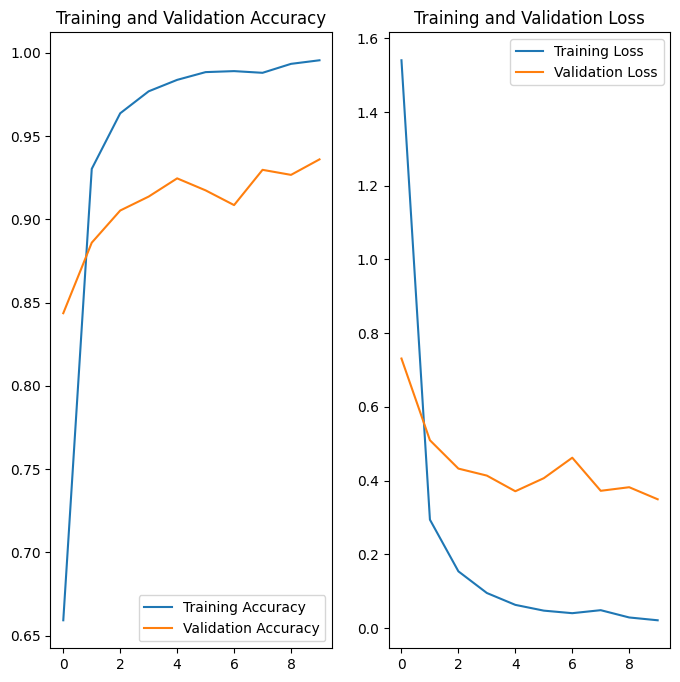

43/43 [==============================] - 4s 101ms/step - loss: 0.3494 - accuracy: 0.9360


In [19]:
acc_loss_eval(history_4, model_4)

<div class="alert alert-block alert-info" style="color: #000000;">
Decreasing Adam learning rate from 0.01 to 0.001 increased the accuracy of our model .

</div>

## Dropout layer

<div class="alert alert-block alert-info" style="color: #000000;">

There is a special layer type that helps reducing overfitting the data - Dropout layer.
It randomly selects a predefined fraction of nodes to be turned off. With every update randm nodes are turned off and it forces the neural network to use various combinations of nodes to classify the same data. In general, the network will be more versatile.

</div>

In [20]:
 model_5 = Sequential([
     Conv2D(60, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'), 
     Conv2D(60, (5, 5), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
    
     Conv2D(30, (3, 3), activation='relu'),
     Conv2D(30, (3, 3), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
    
     Flatten(),
     Dense(500, activation='relu'),
     Dropout(0.5),
     Dense(CLASSES, activation='softmax')
])
model_5.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_5 = model_5.fit(train_data_gen, 
                      steps_per_epoch = int(np.ceil(train_data_gen.samples / 100)),
                      epochs=10,
                      validation_data=val_data_gen,
                      validation_steps = int(np.ceil(val_data_gen.samples / 100)),
                      verbose=0)

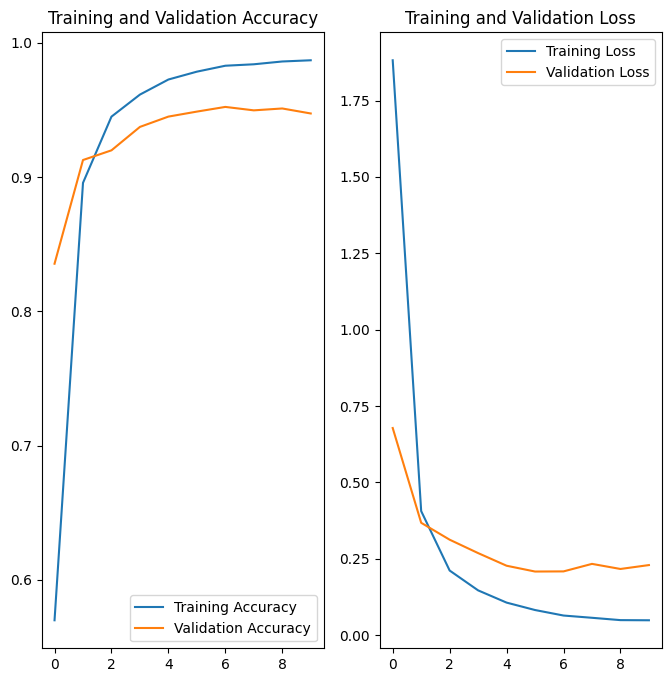

43/43 [==============================] - 4s 101ms/step - loss: 0.2297 - accuracy: 0.9474


In [22]:
acc_loss_eval(history_5, model_5)

<div class="alert alert-block alert-info" style="color: #000000;">

Notice how Dropout layer decreased the distance between plot line for training and validation accuracy (losses as well) - they are much closer now.

</div>

# Data Augmentation

<div class="alert alert-block alert-info" style="color: #000000;">

We have a quite good accuracy of our model but still, it is overfitted.
    
Data augmentation will hugely help us with not only generating more data for our model, but it will also prevent overfitting and make the model generalize more on the data it doesn't know.
    
As we are already utilizing ImageDataGenerator, we will use it to augment the data. I will use `shear_range`, `zoom_range`, `brightness_range`, `width_shift_range`, `height_shift_range`, `channel_shift_range`.
</div>

In [23]:
train_image_generator_aug = ImageDataGenerator(rescale=1./255,
                                           shear_range=0.1,
                                           zoom_range=0.2,
                                           brightness_range=[0.5, 1.5],
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           channel_shift_range=0.2)
val_image_generator = ImageDataGenerator(rescale=1./255)

<div class="alert alert-block alert-warning" style="color: #000000;">
    
Important! Don't use `rotation_range` for data augmentation. In case of traffic signs rotating for example an arrow can make a completely different sign. It probably won't give you much benefits and can even confuse the model.
    
</div>

In [24]:
train_data_gen = train_image_generator_aug.flow_from_directory(batch_size=100,
                                                          directory=root_dir + train_dir,
                                                          class_mode='sparse',
                                                          shuffle=True,
                                                          target_size=(IMG_HEIGHT, IMG_WIDTH))

# define validation set
val_data_gen = val_image_generator.flow_from_directory(batch_size=100,
                                                       directory=root_dir + val_dir,
                                                       class_mode='sparse',
                                                       shuffle=False,
                                                       target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 16746 images belonging to 92 classes.
Found 4298 images belonging to 92 classes.


# Model on augmented data

In [25]:
 # the same model as previously
    
final = Sequential([
     Conv2D(60, (5, 5), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'), 
     Conv2D(60, (5, 5), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
    
     Conv2D(30, (3, 3), activation='relu'),
     Conv2D(30, (3, 3), activation='relu'),
     MaxPooling2D(pool_size=(2, 2)),
    
     Flatten(),
     Dense(500, activation='relu'),
     Dropout(0.5),
     Dense(CLASSES, activation='softmax')
])
final.compile(Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

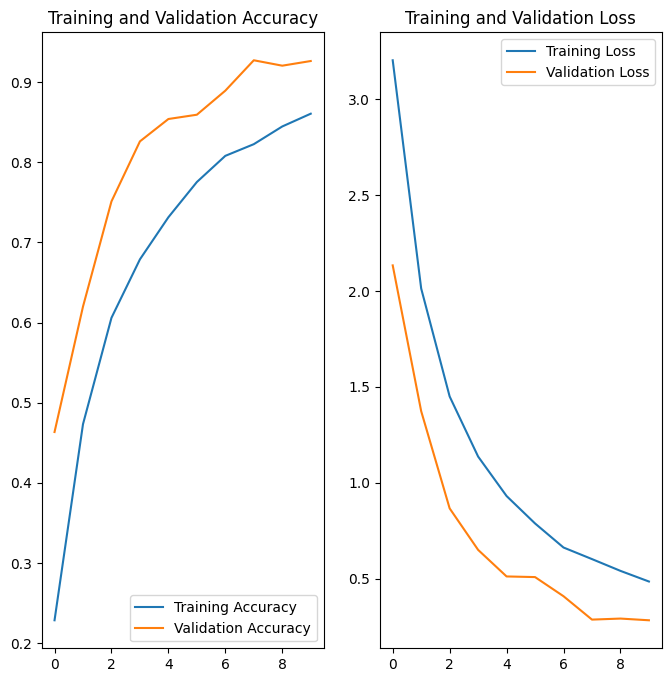

43/43 [==============================] - 4s 102ms/step - loss: 0.2821 - accuracy: 0.9265


In [26]:
history_6 = final.fit(train_data_gen, 
                      steps_per_epoch = int(np.ceil(train_data_gen.samples / 100)),
                      epochs=10,
                      validation_data=val_data_gen,
                      validation_steps = int(np.ceil(val_data_gen.samples / 100)),
                      verbose=0)

acc_loss_eval(history_6, final)

<div class="alert alert-block alert-info" style="color: #000000;">

The accuracy decreased but now validation accuracy is bigger than testing accuracy - our model learned how to generalize the data it received.
Knowing that, we could run the model for more epochs and probably reach 99%. However, for computational reasons I won't run it here.
</div>

# Credits

<div class="alert alert-block alert-info" style="color: #000000;">

This notebook is strongly based and inspired on <a href="https://www.packtpub.com/product/the-complete-self-driving-car-course-applied-deep-learning-video/9781838829414">The Complete Self-Driving Car Course - Applied Deep Learning from Packt</a>. 
</div>

# Appendix: Function for testing

<div class="alert alert-block alert-info" style="color: #000000;">

This code can be used to test the model on images from the internet.
    
</div>

In [27]:
from PIL import Image
import requests

In [28]:
dict_of_urls = { 'A-17': 'https://znaki-drogowe.pl/img/ostrzegawcze/A-17-dzieci.png',
               'D-40': 'https://znaki-drogowe.pl/img/informacyjne/D-40-strefa-zamieszkania.png',
               'B-41': 'https://znaki-drogowe.pl/img/zakazu/B-41-zakaz-ruchu-pieszych.png',
               'C-2': 'https://znaki-drogowe.pl/img/nakazu/C-2-nakaz-jazdy-w-prawo-za-znakiem.png'}

In [29]:
def testing(model, dict_of_urls=dict_of_urls):
    for name, url in dict_of_urls.items():
        r = requests.get(url, stream=True)
        image = Image.open(r.raw)
        image = image.resize((IMG_HEIGHT, IMG_WIDTH))
        image_arr = np.array(image.convert('RGB'))
        image_arr.shape = (1, IMG_HEIGHT, IMG_WIDTH, 3)
        result = model.predict(image_arr, verbose=0)
        ind = np.argmax(result)
        classes = list(train_data_gen.class_indices.keys())
        pred = classes[ind]
        
        plt.imshow(image)
        plt.show()
        print('The traffic sign is {}. Model predicted: {}.\n\n'.format(name, pred))   

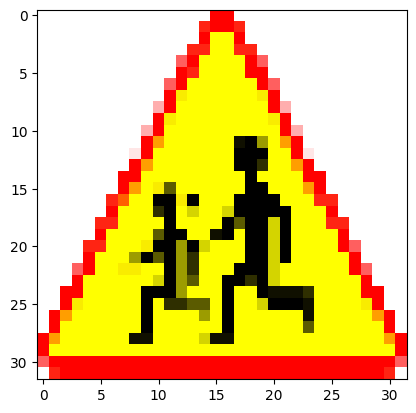

The traffic sign is A-17. Model predicted: A-17.




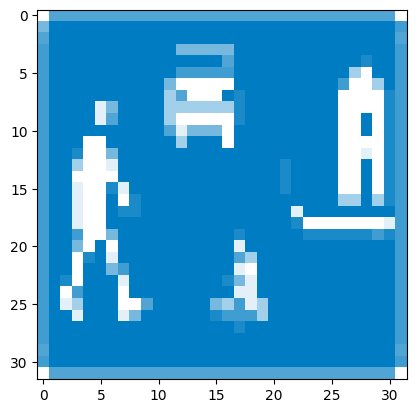

The traffic sign is D-40. Model predicted: D-40.




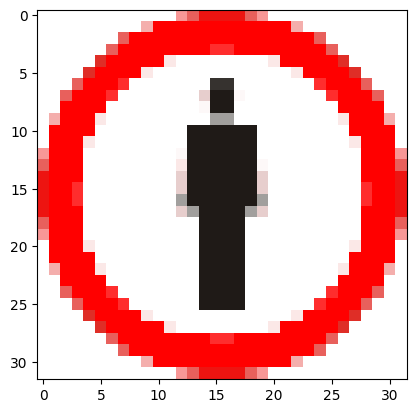

The traffic sign is B-41. Model predicted: B-41.




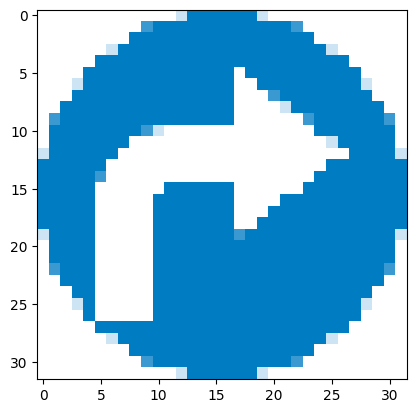

The traffic sign is C-2. Model predicted: C-2.




In [30]:
testing(basic)